# Results Notebook
<hr style="clear:both">

This notebook presents our results for the ADA Milestone 3 project. In this analysis, we will demonstrate how we merged the three datasets used in the project:
 * [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)
 * [Full TMDB Movies Dataset 2024](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data)
 * [MovieLens Tag Genome Dataset 2021](https://grouplens.org/datasets/movielens/) 

Additionally, we will explore the use of sentiment analysis (for more details, refer to the `sentiment_analysis.ipynb` notebook) and other movie features to compute a success score for a movie. This will be used to compute a future best genre prediction. For better comprehension of the different techniques such as the prediction method, see the `methods.ipynb` notebook.


**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
from typing import final
import pandas as pd
import numpy as np
import os

from src.models.Impact import impact_genre
import matplotlib.cm as cm
from src.models.PolynomialRegression import polynomial_regression
from src.models.ARIMA import arima
from src.utils.print_prediction import plot_results

import warnings
warnings.filterwarnings('ignore')
from src.utils.results_utils import *
from matplotlib import pyplot as plt
from src.utils.results_utils import *

## Loading the "_CMU Movie Summary Corpus_" dataset

In [3]:
# Giving an appropriate name to the columns
movie_headers = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]
movie_headers = [header.lower().replace(' ', '_') for header in movie_headers]

In [4]:
# Loading the CMU Movie Dataset and showing the first 5 rows
movies_df = pd.read_csv("./data/MovieSummaries/movie.metadata.tsv", sep="\t", header=None, names=movie_headers)
print_df_size("MoviesSummaries", movies_df)
movies_df.head()

MoviesSummaries - shape: (81741, 9) --> 81741 rows and 9 columns


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## Loading the "_TMDB_" dataset

In [5]:
# Loading the TMDB Movie Dataset and showing the first 5 rows
tmdb_movies_df = pd.read_csv("./data/TMDBMovies/TMDB_movie_dataset_v11.csv")
print_df_size("TMDB", tmdb_movies_df)
tmdb_movies_df.head()

TMDB - shape: (1139790, 24) --> 1139790 rows and 24 columns


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


## Merging the "_CMU Movie Summary Corpus_" with the "_TMDB_" datasets

In [6]:
# Loading the Converter file and merging the CMU Movie Summary Corpus with the TMDB datasets on the freebase ids
query_df = pd.read_csv("./data/Converter/query.csv", sep=',', header=0)
tmdb_with_ids_df = tmdb_movies_df.merge(query_df, how='inner', on='imdb_id')
full_merged = pd.merge(movies_df, tmdb_with_ids_df, left_on='freebase_movie_id', right_on='freebase_id', how='inner')
print_df_size("CMU & TMDB", full_merged)
full_merged.head()

CMU & TMDB - shape: (68433, 34) --> 68433 rows and 34 columns


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,id,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016,...,"In 2176, a Martian police unit is sent to pick...",14.189,/i2zztssCIbahGES1fdfWFmDXian.jpg,Terror is the same on any planet.,"Action, Horror, Science Fiction","Animationwerks, Screen Gems, Storm King Produc...",United States of America,English,"future, planet mars, anti hero, possession, ho...",/m/03vyhn
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579,...,Dramatization of the story behind the murder o...,0.600,NaN,NaN,"Drama, Crime",NaN,United States of America,English,"colorado, jonbenet",/m/08yl5d
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302,...,A stolen bicycle case ends with drunken detect...,0.898,/rtFEOQQ0LVDv7y2bCgVVg3wWpXK.jpg,A film about murder and love,"Mystery, Crime, Drama","Filmeffekt AS, Norsk Film",Norway,Norwegian,"bicycle, private detective",/m/0crgdbh
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592,...,"In a wealthy and isolated desert community, a ...",8.297,/aLFoGmQpknOvcyx4imCP7Fuvoip.jpg,No woman is safe… while he is loose!,"Horror, Thriller",Mrs. White's Productions,United Kingdom,English,"based on novel or book, gas station, psychopat...",/m/0285_cd
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192,...,"Eva, an upper-class housewife, frustratedly le...",2.801,/iKeCVR0x8vnRXLtjwjZ7EuVFlo7.jpg,NaN,Drama,Dieter Geissler Filmproduktion,Germany,German,"jealousy, eroticism, gigolo, longing, dominatr...",/m/01mrr1


In [7]:
full_reduced = merge_cmu_tmdb_clean_columns(full_merged)
full_reduced.head()

,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_countries,movie_genres,vote_average,vote_count,release_date,revenue,popularity,genres,production_countries
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,2001-08-24,14010832,14.189,"Action, Horror, Science Fiction",United States of America
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,"{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.000,0,2000-02-16,0,0.600,"Drama, Crime",United States of America
2,/m/0crgdbh,Brun bitter,1988,NaN,"{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",0.000,0,1988-11-17,0,0.898,"Mystery, Crime, Drama",Norway
3,/m/0285_cd,White Of The Eye,1987,NaN,"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,1987-06-19,0,8.297,"Horror, Thriller",United Kingdom
4,/m/01mrr1,A Woman in Flames,1983,NaN,"{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.300,13,1983-05-11,0,2.801,Drama,Germany


In [8]:
# Cleaning the columns that contain dictionaries
full_reduced = merge_cmu_tmdb_remove_dictionaries(full_reduced)
full_reduced.head()

,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,vote_average,vote_count,release_date,revenue,popularity,movie_countries_final,movie_genres_final
0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,5.127,977,2001-08-24,14010832,14.189,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,0.000,0,2000-02-16,0,0.600,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,/m/0crgdbh,Brun bitter,1988,NaN,0.000,0,1988-11-17,0,0.898,Norway,"Crime Fiction, Drama"
3,/m/0285_cd,White Of The Eye,1987,NaN,5.742,64,1987-06-19,0,8.297,United Kingdom,"Thriller, Erotic thriller, Psychological thriller"
4,/m/01mrr1,A Woman in Flames,1983,NaN,5.300,13,1983-05-11,0,2.801,Germany,Drama


In [9]:
full_reduced = merge_cmu_tmdb_combine_columns(full_reduced)
full_reduced.head()

,freebase_movie_id,movie_name,vote_average,vote_count,popularity,movie_countries_final,movie_genres_final,combined_release_date,Box_Office
0,/m/03vyhn,Ghosts of Mars,5.127,977,14.189,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001-08-24,14010832.0
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,0.000,0,0.600,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000-02-16,NaN
2,/m/0crgdbh,Brun bitter,0.000,0,0.898,Norway,"Crime Fiction, Drama",1988-11-17,NaN
3,/m/0285_cd,White Of The Eye,5.742,64,8.297,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987-06-19,NaN
4,/m/01mrr1,A Woman in Flames,5.300,13,2.801,Germany,Drama,1983-05-11,NaN


In [13]:
# Drop the rows that have either empty release dates or genres or countries because these are the main features we will use
# We keep the one with empty box office revenue as to compute our sucess metric,
# we use it when we have it and when we don't we just ignore it.
full_reduced = full_reduced.dropna(subset=['combined_release_date', 'movie_genres_final', 'movie_countries_final', 'popularity'])
print_df_size("full_reduced", full_reduced)
full_reduced.head()

full_reduced - shape: (67149, 9) --> 67149 rows and 9 columns


,freebase_movie_id,movie_name,vote_average,vote_count,popularity,movie_countries_final,movie_genres_final,combined_release_date,Box_Office
0,/m/03vyhn,Ghosts of Mars,5.127,977,14.189,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001-08-24,14010832.0
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,0.000,0,0.600,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000-02-16,NaN
2,/m/0crgdbh,Brun bitter,0.000,0,0.898,Norway,"Crime Fiction, Drama",1988-11-17,NaN
3,/m/0285_cd,White Of The Eye,5.742,64,8.297,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987-06-19,NaN
4,/m/01mrr1,A Woman in Flames,5.300,13,2.801,Germany,Drama,1983-05-11,NaN


In [14]:
#save this dataframe in a pickle file for faster loading
full_reduced.to_pickle("./data/CMU_and_TDB.pkl")

## Loading the "_MovieLens_" dataset

In [15]:
# Load the MovieLens dataset
added_movies = pd.read_json('./data/MovieLens/raw/metadata_updated.json', lines=True)
added_movies["imdbId"] = added_movies["imdbId"].astype(str)
print_df_size("MovieLens", added_movies)
added_movies.head()

MovieLens - shape: (84661, 6) --> 84661 rows and 6 columns


,title,directedBy,starring,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",3.07620,113041,5


## Merging the "_CMU Movie Summary Corpus_", "_TMDB_" and "_MovieLens_" datasets

In [24]:
# Loading the Converter file and merging the CMU Movie Summary Corpus with the TMDB datasets on the freebase ids
converter = pd.read_csv('./data/Converter/query.csv')
converter["imdb_id"] = converter["imdb_id"].str[3:]
merged_data = pd.merge(full_reduced, converter, left_on="freebase_movie_id", right_on="freebase_id", how='inner')
merged_data = merged_data.drop_duplicates(subset='freebase_movie_id', keep='first')

In [25]:
# Merge the MovieLens data with the two already merged datasets
final_data = pd.merge(merged_data, added_movies, left_on='imdb_id', right_on="imdbId", how='left')
columns_to_drop = ['title','directedBy', 'starring', 'imdbId', 'freebase_id']
filtered_final_data = final_data.drop(columns=columns_to_drop)
print_df_size("filtered final data", filtered_final_data)
filtered_final_data.head()

filtered final data - shape: (67094, 12) --> 67094 rows and 12 columns


,freebase_movie_id,movie_name,vote_average,vote_count,popularity,movie_countries_final,movie_genres_final,combined_release_date,Box_Office,imdb_id,avgRating,item_id
0,/m/03vyhn,Ghosts of Mars,5.127,977,14.189,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001-08-24,14010832.0,228333,2.35723,4735.0
1,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,0.000,0,0.600,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000-02-16,NaN,245916,NaN,NaN
2,/m/0crgdbh,Brun bitter,0.000,0,0.898,Norway,"Crime Fiction, Drama",1988-11-17,NaN,094806,NaN,NaN
3,/m/0285_cd,White Of The Eye,5.742,64,8.297,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987-06-19,NaN,094320,NaN,NaN
4,/m/01mrr1,A Woman in Flames,5.300,13,2.801,Germany,Drama,1983-05-11,NaN,083949,NaN,NaN


In [26]:
# Save the final data in a pickle file for faster loading
filtered_final_data.to_pickle("./data/Three_Datasets_Combined.pkl")

## Loading the "_MovieLens Reviews_" dataset
This is part of our MovieLens dataset, it contains the reviews of the movies.

In [54]:
# Load the reviews dataset, as it takes a lot of time to load we directly save it in a pickle file
#reviews_df = pd.read_json('./data/MovieLens/raw/reviews.json', lines=True)
#reviews_df.to_pickle('./data/reviews.pkl')

## Preparing the reviews dataset for the sentiment analysis

In [28]:
# For faster loading we will load the reviews from the pickle file
reviews_df = pd.read_pickle('./data/reviews.pkl')
print_df_size("Number of reviews", reviews_df)
print("The number of unique movies in the reviews dataset is: ", reviews_df['item_id'].nunique())
reviews_df.head()

Number of reviews - shape: (2624608, 2) --> 2624608 rows and 2 columns
The number of unique movies in the reviews dataset is:  52081


,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita..."
1,95541,Banging Away..; Thomas Edison and William K.L....
2,7065,unbelievable; I cannot understand how anyone c...
3,3739,I'm still starry-eyed from it; I saw this last...
4,1562,Failed on every Front; Joel Schumacher who did...


In [29]:
# We are only going to apply sentiment analysis on the reviews that are available in our merged dataset
# This particular step is to keep track of the review number/order
reviews_df = reviews_df.reset_index()
merged_reviews = pd.merge(reviews_df, filtered_final_data, left_on='item_id', right_on='item_id', how='inner')
merged_reviews = merged_reviews.sort_values(by='item_id')
merged_reviews = merged_reviews.rename(columns={'txt': 'review'})
print_df_size("merged reviews", merged_reviews)
merged_reviews.head()

merged reviews - shape: (1293847, 14) --> 1293847 rows and 14 columns


,index,item_id,review,freebase_movie_id,movie_name,vote_average,vote_count,popularity,movie_countries_final,movie_genres_final,combined_release_date,Box_Office,imdb_id,avgRating
260872,412847,1,Fantastic Revolutionary Computer Animation Cla...,/m/0dyb1,Toy Story,7.971,17152,78.404,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995-10-30,361958736.0,114709,3.89146
828262,2044033,1,The best film for small children....; My toddl...,/m/0dyb1,Toy Story,7.971,17152,78.404,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995-10-30,361958736.0,114709,3.89146
463118,757613,1,Toy Story was like the Snow White of 1995; I r...,/m/0dyb1,Toy Story,7.971,17152,78.404,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995-10-30,361958736.0,114709,3.89146
642563,1325676,1,Timeless Animation; Toy Story came out right i...,/m/0dyb1,Toy Story,7.971,17152,78.404,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995-10-30,361958736.0,114709,3.89146
409172,658384,1,A timeless classic.; Toy Story is truly a grou...,/m/0dyb1,Toy Story,7.971,17152,78.404,United States of America,"Buddy film, Adventure, Children's/Family, Comp...",1995-10-30,361958736.0,114709,3.89146


In [30]:
# Final dataset for sentiment analysis
merged_reviews.to_pickle('./data/merged_data_with_reviews.pkl')

## Loading the sentiment analysis output
For more information on sentiment analysis, see the notebook sentiment_analysis.ipynb

In [31]:
df_sa = pd.read_csv('./data/sentiment_analysis.csv')
df_sa.head()

,Unnamed: 0,sentiment_analysis,item_id,index
0,828299,"{'label': 'NEGATIVE', 'score': 0.9858629107475...",1,2044046
1,828302,"{'label': 'POSITIVE', 'score': 0.9998522996902...",1,2044054
2,828305,"{'label': 'POSITIVE', 'score': 0.9990456700325...",1,2044063
3,828306,"{'label': 'POSITIVE', 'score': 0.9998844861984...",1,2044069
4,828308,"{'label': 'POSITIVE', 'score': 0.9972469806671...",1,2044077


In [32]:
# Split the sentiment_analysis column into two columns, one for the label and one for the score
df_sa['sentiment_analysis'] = df_sa['sentiment_analysis'].apply(eval)
df_sa[['label', 'score']] = df_sa['sentiment_analysis'].apply(pd.Series)
# Remove unnecessary columns
df_sa.drop(columns=['sentiment_analysis', "Unnamed: 0", "index"], inplace=True)
# Replace the labels with 0 and 1
df_sa['label'] = df_sa['label'].replace({'NEGATIVE': 0, 'POSITIVE': 1})
df_sa.head()

,item_id,label,score
0,1,0,0.985863
1,1,1,0.999852
2,1,1,0.999046
3,1,1,0.999884
4,1,1,0.997247


In [33]:
# getting the mean per item id and apply penalty for items that have low number of reviews
mean_sa = df_sa.groupby('item_id')['label'].mean().reset_index()
mean_sa['count'] = df_sa.groupby('item_id').size().reset_index(name='count')['count']
mean_sa['penalty'] = 1 - 0.5**mean_sa['count']
mean_sa['sa_score']=mean_sa['label']*mean_sa['penalty']
mean_sa.drop(columns=['label', 'count', 'penalty'], inplace=True)
mean_sa.head()

,item_id,sa_score
0,1,0.912114
1,2,0.775148
2,3,0.716667
3,4,0.632653
4,5,0.666667


## Adding the sentiment analysis score to the dataset

Now we add the sentiment analysis score to our dataset. Some movies may not have a sentiment analysis score, but, again, we keep them because we don't need all the metrics to compute our succes metric.

In [41]:
df_three_datasets_combined = pd.read_pickle("./data/Three_Datasets_Combined.pkl")
df_final = df_three_datasets_combined.merge(mean_sa, on='item_id', how='left')
# Specify the desired order of columns
desired_order = ['freebase_movie_id', 'imdb_id', 'item_id', 'movie_name', 'combined_release_date', 'movie_countries_final', 'movie_genres_final', 'Box_Office', 'sa_score', 'avgRating', 'vote_average', 'vote_count', 'popularity']  # Replace with your column names
df_final = df_final.reindex(columns=desired_order)
df_final.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,sa_score,avgRating,vote_average,vote_count,popularity
0,/m/03vyhn,228333,4735.0,Ghosts of Mars,2001-08-24,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",14010832.0,0.351293,2.35723,5.127,977,14.189
1,/m/08yl5d,245916,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,United States of America,"Mystery, Biographical film, Drama, Crime Drama",NaN,NaN,NaN,0.000,0,0.600
2,/m/0crgdbh,094806,NaN,Brun bitter,1988-11-17,Norway,"Crime Fiction, Drama",NaN,NaN,NaN,0.000,0,0.898
3,/m/0285_cd,094320,NaN,White Of The Eye,1987-06-19,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",NaN,NaN,NaN,5.742,64,8.297
4,/m/01mrr1,083949,NaN,A Woman in Flames,1983-05-11,Germany,Drama,NaN,NaN,NaN,5.300,13,2.801


Saving the three datasets merged and with the sentiment analysis score.

In [35]:
# Save the dataset with sentiment analysis score in a pickle file
df_final.to_pickle("./data/OurFinalDataset.pkl")

# Box Office Revenue with Inflation

Now we still need to take into account the inflation for the box office revenue.

In [43]:
from typing import final
import pandas as pd
import numpy as np
from src.utils.results_utils import *
from matplotlib import pyplot as plt

In [46]:
# We load the final dataset.
final_dataset = pd.read_pickle('./data/OurFinalDataset.pkl')
final_dataset.replace(0, np.nan, inplace=True)
final_dataset.dropna(subset=['popularity'], inplace=True)
final_dataset.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,sa_score,avgRating,vote_average,vote_count,popularity
0,/m/03vyhn,228333,4735.0,Ghosts of Mars,2001-08-24,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",14010832.0,0.351293,2.35723,5.127,977.0,14.189
1,/m/08yl5d,245916,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,United States of America,"Mystery, Biographical film, Drama, Crime Drama",NaN,NaN,NaN,NaN,NaN,0.600
2,/m/0crgdbh,094806,NaN,Brun bitter,1988-11-17,Norway,"Crime Fiction, Drama",NaN,NaN,NaN,NaN,NaN,0.898
3,/m/0285_cd,094320,NaN,White Of The Eye,1987-06-19,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",NaN,NaN,NaN,5.742,64.0,8.297
4,/m/01mrr1,083949,NaN,A Woman in Flames,1983-05-11,Germany,Drama,NaN,NaN,NaN,5.300,13.0,2.801


In [47]:
# Checking for missing values
final_dataset.isna().sum()

freebase_movie_id            0
imdb_id                      0
item_id                  52369
movie_name                   0
combined_release_date        0
movie_countries_final        0
movie_genres_final           0
Box_Office               55167
sa_score                 54885
avgRating                53322
vote_average              9678
vote_count                9687
popularity                   0
dtype: int64

missing item_id is not a problem because that just mean that it comes from the CMU dataset.

In [53]:
# We don't have information about inflation before 1913, so we will apply the 1913 inflation rates to the oldest movies
final_dataset['adjusted_release_date'] = final_dataset['combined_release_date'].apply(inflation_date_constraint)
final_dataset.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,sa_score,avgRating,vote_average,vote_count,popularity,adjusted_release_date
0,/m/03vyhn,228333,4735.0,Ghosts of Mars,2001-08-24,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",14010832.0,0.351293,2.35723,5.127,977.0,14.189,2001-08-24
1,/m/08yl5d,245916,NaN,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,United States of America,"Mystery, Biographical film, Drama, Crime Drama",NaN,NaN,NaN,NaN,NaN,0.600,2000-02-16
2,/m/0crgdbh,094806,NaN,Brun bitter,1988-11-17,Norway,"Crime Fiction, Drama",NaN,NaN,NaN,NaN,NaN,0.898,1988-11-17
3,/m/0285_cd,094320,NaN,White Of The Eye,1987-06-19,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",NaN,NaN,NaN,5.742,64.0,8.297,1987-06-19
4,/m/01mrr1,083949,NaN,A Woman in Flames,1983-05-11,Germany,Drama,NaN,NaN,NaN,5.300,13.0,2.801,1983-05-11


In [ ]:
import cpi
from tqdm import tqdm

cpi.update()

# Our column is already in datetime format, but we doublecheck
final_dataset['combined_release_date'] = pd.to_datetime(final_dataset['combined_release_date'], errors='coerce')

# We are going to adjust the inflation to the latest year in the dataset so we have a comparable metric
max_year = final_dataset['adjusted_release_date'].dt.year.max()

# It takes time so we use tqdm to show the progress
tqdm.pandas()

# We compute the inflation adjusted box office revenue and skip the NaN values
final_dataset['inflation_adjusted_box_office_revenue']=final_dataset.progress_apply(
    lambda r: cpi.inflate(r['Box_Office'], r['adjusted_release_date'].year, to=max_year) if pd.notna(r['Box_Office']) else np.nan,
    axis=1
)
# We directly save the dataset to a pickle file because the conversion takes 30 min
final_dataset.to_pickle('./data/Box_Office_Inflation.pkl')

One Final Modification to reoder the columns

In [127]:
# Reorder the columns and sorting the dataset by popularity
data_box_office = pd.read_pickle('./data/Box_Office_Inflation.pkl')
data_box_office.head()
desired_order = ['freebase_movie_id', 'imdb_id', 'item_id', 'movie_name', 'combined_release_date',  'Box_Office', 'inflation_adjusted_box_office_revenue','movie_countries_final', 'movie_genres_final', 'sa_score', 'avgRating', 'vote_average', 'vote_count', 'popularity']
data_box_office = data_box_office.reindex(columns=desired_order)
data_box_office = data_box_office.sort_values(by='popularity', ascending=False)
data_box_office = data_box_office.sort_values(by='popularity', ascending=False)
data_box_office.to_pickle('./data/Data_For_Score.pkl')
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,avgRating,vote_average,vote_count,popularity
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,4.000000e+07,1.126679e+08,United States of America,"Thriller, Cold War, Action/Adventure, Drama, W...",NaN,NaN,6.272,691.0,300.738
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,2.320250e+09,2.320250e+09,United States of America,"Science Fiction, Action, Fantasy, Adventure",NaN,NaN,7.654,9830.0,241.285
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"Softcore Porn, Comedy, World cinema, Adult",0.776259,3.42308,4.800,335.0,232.565
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"Thriller, Horror, Slasher, Psychological thriller",0.257778,1.98768,4.500,353.0,225.504
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,9.747554e+08,1.610768e+09,"United States of America, United Kingdom","Fantasy Adventure, Adventure, Children's/Famil...",0.639775,3.68820,7.916,25379.0,185.482


# Success Metric
Now we have collected all the data we need, and we can compute our success metric. This metric is based on the popularity score of the TMDB dataset. This wonderful takes into accounnt, the number of person who who marked it as a "favourite" for the day, number of users who added it to their "watchlist" for the day, the release date, the number of total vote, number of votes for the day, number of views per day and most importantly, the previous day's popularity score. This combinations makes it a very good metric to evaluate the success of a movie as it takes into account every attention a movie gets, the score but also it keeps old movies relevant because it takes into account it's popularity at the release date. We are going to smartly finetune this metric by adding to it the box office revenue (inflation adjusted), the average rating taken from IMDB and the reviews sentiment analysis score.

In [6]:
data_box_office = pd.read_pickle('./data/Data_For_Score.pkl')

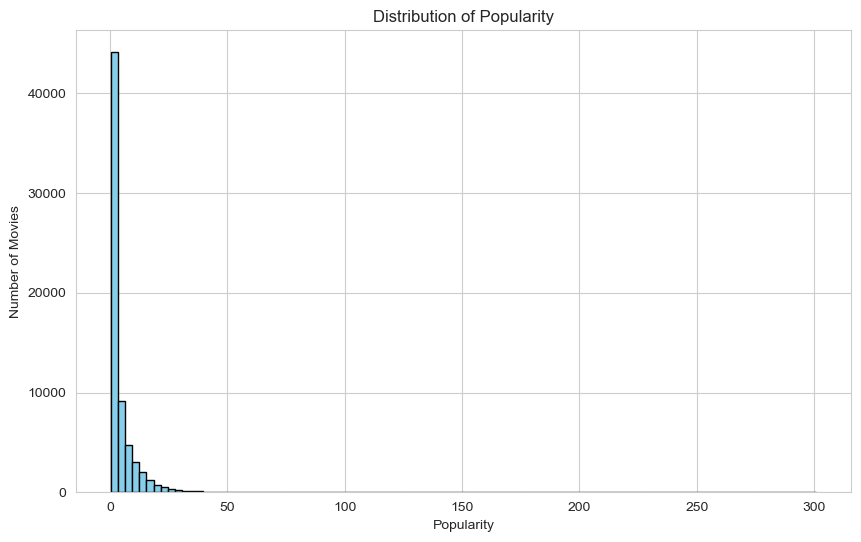

In [7]:
# Let's explore the TMDB popularity distribution
plt.figure(figsize=(10, 6))
plt.hist(data_box_office['popularity'],bins=100,color='skyblue',edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Movies')
plt.show()

In [8]:
data_box_office[data_box_office['popularity'] > 28].shape

(1037, 14)

Here we see that the popularity metric is unbounded but only 1000 movies have popularity score above 28. We will clip the popularity score to 28 so we can have a nicer distribution.

In [9]:
data_box_office['popularity'] = data_box_office['popularity'].clip(upper=28)

Here we add the last component of our score which is the genre popularity, so we can have a more complete score.

In [10]:
# Compute the genre fame in our dataset
data_box_office['movie_genres_final'] = data_box_office['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
df_genres = data_box_office.explode('movie_genres_final')
genre_counts = df_genres['movie_genres_final'].value_counts()
genre_counts.head()

movie_genres_final
Drama              30088
Comedy             15138
Romance Film        9156
Thriller            8073
Black-and-white     7977
Name: count, dtype: int64

In [11]:
# We normalize the columns we are going to use to compute our success metric using a scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = ['avgRating', 'vote_average', 'popularity', 'Box_Office', 'inflation_adjusted_box_office_revenue']
data_box_office[columns_to_normalize] = scaler.fit_transform(data_box_office[columns_to_normalize])

In [12]:
# Penalize ratings with low number of votes
data_box_office["vote_avg"] = data_box_office.apply(
    lambda row: max(0, row["vote_average"] - 0.5 ** row["vote_count"]), axis=1
)
columns_to_drop = ['vote_average', 'vote_count']
data_box_office = data_box_office.drop(columns=columns_to_drop)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,avgRating,popularity,vote_avg
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"[Thriller, Cold War, Action/Adventure, Drama, ...",NaN,NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"[Science Fiction, Action, Fantasy, Adventure]",NaN,NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"[Softcore Porn, Comedy, World cinema, Adult]",0.776259,0.649573,1.0,0.452632
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"[Thriller, Horror, Slasher, Psychological thri...",0.257778,0.330596,1.0,0.421053
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","[Fantasy Adventure, Adventure, Children's/Fami...",0.639775,0.708489,1.0,0.780632


In [13]:
# Combine the ratings
data_box_office = combine_ratings(data_box_office)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"[Thriller, Cold War, Action/Adventure, Drama, ...",NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"[Science Fiction, Action, Fantasy, Adventure]",NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"[Softcore Porn, Comedy, World cinema, Adult]",0.776259,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"[Thriller, Horror, Slasher, Psychological thri...",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","[Fantasy Adventure, Adventure, Children's/Fami...",0.639775,1.0,0.744560


In [14]:
# Replace 0 with NaN in the 'popularity' and 'rating' columns
data_box_office['rating'] = data_box_office['rating'].replace(0, np.nan)
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"[Thriller, Cold War, Action/Adventure, Drama, ...",NaN,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"[Science Fiction, Action, Fantasy, Adventure]",NaN,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,NaN,NaN,Italy,"[Softcore Porn, Comedy, World cinema, Adult]",0.776259,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,NaN,NaN,United States of America,"[Thriller, Horror, Slasher, Psychological thri...",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","[Fantasy Adventure, Adventure, Children's/Fami...",0.639775,1.0,0.744560


In [15]:
data_box_office.isna().sum()

freebase_movie_id                            0
imdb_id                                      0
item_id                                  52369
movie_name                                   0
combined_release_date                        0
Box_Office                               55167
inflation_adjusted_box_office_revenue    55167
movie_countries_final                        0
movie_genres_final                           0
sa_score                                 54885
popularity                                   0
rating                                   11834
dtype: int64

In [16]:
columns_to_fill = ['rating', 'sa_score', 'inflation_adjusted_box_office_revenue', 'Box_Office']
data_box_office[columns_to_fill] = data_box_office[columns_to_fill].fillna(data_box_office[columns_to_fill].mean())
data_box_office.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating
64821,/m/01n910,087985,NaN,Red Dawn,1984-08-10,0.014377,0.013326,United States of America,"[Thriller, Cold War, Action/Adventure, Drama, ...",0.619947,1.0,0.607579
42148,/m/0gmbk1g,630029,NaN,Avatar 2,2022-12-14,0.833940,0.274440,United States of America,"[Science Fiction, Action, Fantasy, Adventure]",0.619947,1.0,0.753053
62959,/m/0gdpng,104014,154996.0,All Ladies Do It,1992-02-21,0.014450,0.009824,Italy,"[Softcore Porn, Comedy, World cinema, Adult]",0.776259,1.0,0.551102
4726,/m/03m9db,283877,27473.0,American Psycho 2,2002-04-22,0.014450,0.009824,United States of America,"[Thriller, Horror, Slasher, Psychological thri...",0.257778,1.0,0.375824
58645,/m/03176f,241527,4896.0,Harry Potter and the Philosopher's Stone,2001-11-16,0.350345,0.190522,"United States of America, United Kingdom","[Fantasy Adventure, Adventure, Children's/Fami...",0.639775,1.0,0.744560


In [17]:
data_box_office.isna().sum()

freebase_movie_id                            0
imdb_id                                      0
item_id                                  52369
movie_name                                   0
combined_release_date                        0
Box_Office                                   0
inflation_adjusted_box_office_revenue        0
movie_countries_final                        0
movie_genres_final                           0
sa_score                                     0
popularity                                   0
rating                                       0
dtype: int64

In [18]:
# Compute the success score on our dataframe
data_box_office = success(data_box_office, 'popularity', 'inflation_adjusted_box_office_revenue', 'sa_score', 'rating')

best_succes_movies = data_box_office
best_succes_movies

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,0.143767,0.996126,United States of America,"[Film adaptation, Costume drama, Roadshow thea...",0.619947,1.000000,0.785789,22.186218,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,0.149518,1.000000,United States of America,"[Romance Film, Musical, Fantasy, Family Film, ...",0.619947,1.000000,0.696421,21.949103,4.944015
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,0.096125,0.567962,United States of America,"[Adventure, Children's/Family, Animation, Comi...",0.619947,1.000000,0.684211,18.456170,4.119294
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,0.278692,0.442916,United States of America,"[Science Fiction, Adventure, Fantasy, Coming o...",0.619947,1.000000,0.810947,17.836009,3.972866
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,0.785462,0.471324,United States of America,"[Tragedy, Costume drama, Historical fiction, A...",0.592075,1.000000,0.714080,17.689057,3.938169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21553,/m/051zjm2,457124,181519.0,Satan War,1979-10-24,0.014450,0.009824,United States of America,[Horror],0.234375,0.000000,0.108845,1.108254,0.023254
2401,/m/0fqqm2h,195039,91960.0,The Magic Christmas Tree,1964-12-19,0.014450,0.009824,United States of America,"[Family Film, Fantasy]",0.199994,0.006314,0.121412,1.105950,0.022710
12696,/m/05pcssh,902274,157093.0,Death on Demand,2008-01-01,0.014450,0.009824,United States of America,"[B-movie, Horror, Slasher, Haunted House Film]",0.110894,0.000000,0.222222,1.077943,0.016097
39504,/m/05f965s,120200,176195.0,Starquest II,1996-01-01,0.014450,0.009824,United States of America,"[Thriller, Science Fiction]",0.055555,0.048796,0.107977,1.057147,0.011187


In [19]:
# Adjust the columns order
desired_order = ['freebase_movie_id', 'imdb_id', 'item_id', 'movie_name', 'combined_release_date', 'movie_countries_final', 'movie_genres_final', 'Box_Office', 'inflation_adjusted_box_office_revenue',  'sa_score', 'rating', 'popularity', 'success_score', 'success_metric_scaled']
best_succes_movies = best_succes_movies.reindex(columns=desired_order)
best_succes_movies.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,inflation_adjusted_box_office_revenue,sa_score,rating,popularity,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,United States of America,"[Film adaptation, Costume drama, Roadshow thea...",0.143767,0.996126,0.619947,0.785789,1.0,22.186218,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,United States of America,"[Romance Film, Musical, Fantasy, Family Film, ...",0.149518,1.000000,0.619947,0.696421,1.0,21.949103,4.944015
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,United States of America,"[Adventure, Children's/Family, Animation, Comi...",0.096125,0.567962,0.619947,0.684211,1.0,18.456170,4.119294
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,United States of America,"[Science Fiction, Adventure, Fantasy, Coming o...",0.278692,0.442916,0.619947,0.810947,1.0,17.836009,3.972866
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,United States of America,"[Tragedy, Costume drama, Historical fiction, A...",0.785462,0.471324,0.592075,0.714080,1.0,17.689057,3.938169


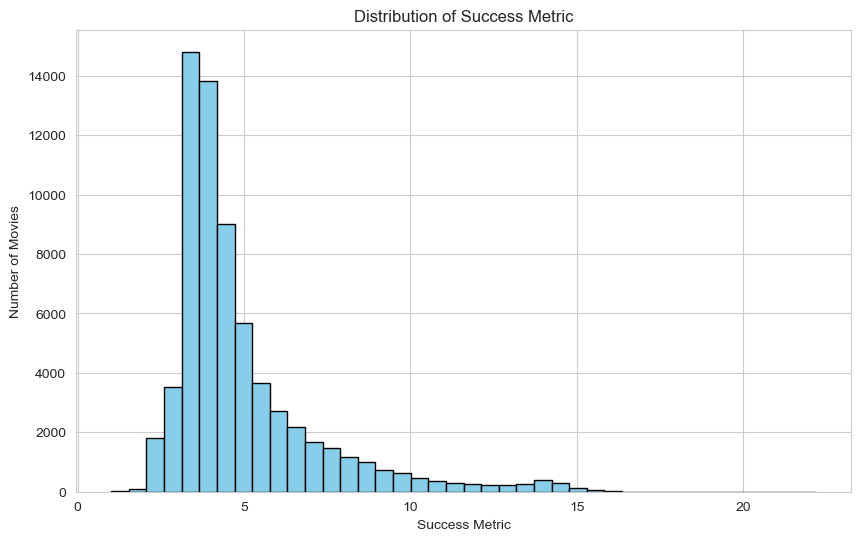

In [20]:
import matplotlib.pyplot as plt

# Create a histogram of the Success_metric
plt.figure(figsize=(10, 6))
plt.hist(data_box_office['success_score'].dropna(), bins=40, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')

# Show the plot
plt.show()

Compute the success of each genre by calculating the mean success score of every movie in that genre.

In [21]:
# Without penalty
# Ensure that the genres column contains a list
data_box_office['movie_genres_final'] = data_box_office['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# Use explode to separate the genres
df_genres = data_box_office.explode('movie_genres_final')
# Group by the genres and compute the mean success metric
mean_success_by_genre = df_genres.groupby('movie_genres_final')['success_score'].mean().reset_index()
# Display the result
best_genres = mean_success_by_genre['success_score']
best_genres = mean_success_by_genre.sort_values(by='success_score', ascending=False)
best_genres.head()

,movie_genres_final,success_score
282,Revisionist Fairy Tale,13.895620
246,Ninja movie,13.854302
325,Statutory rape,13.310204
316,Space opera,12.832295
278,Reboot,12.470685


In [22]:
# With penalty
# Ensure that the genres column contains a list
data_box_office['movie_genres_final'] = data_box_office['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# Use explode to separate the genres
df_genres = data_box_office.explode('movie_genres_final')

# Count the occurrences of each genre and the ratio of appearance
genre_counts = df_genres['movie_genres_final'].value_counts()
total_genre_entries = len(df_genres)
ratio_of_genre = genre_counts / total_genre_entries

# Group by genres and compute the mean success metric
mean_success_by_genre = df_genres.groupby('movie_genres_final')['success_score'].mean().reset_index()

# Merge the mean success score and ratio DataFrames
ratio_of_genre = ratio_of_genre.reset_index()
ratio_of_genre.columns = ['movie_genres_final', 'ratio']
merged_df = pd.merge(mean_success_by_genre, ratio_of_genre, on='movie_genres_final')

# Penalize genres with few movies
merged_df['weighted_success_score'] = merged_df['success_score'] * merged_df['ratio']
merged_df = merged_df.drop(columns=['success_score', 'ratio'])
merged_df = merged_df.sort_values(by='weighted_success_score', ascending=False)
merged_df.head(10)

,movie_genres_final,weighted_success_score
114,Drama,0.697547
75,Comedy,0.374988
345,Thriller,0.228203
290,Romance Film,0.228041
2,Action,0.213238
362,World cinema,0.175168
98,Crime Fiction,0.162400
43,Black-and-white,0.157655
197,Indie,0.135405
5,Action/Adventure,0.135007


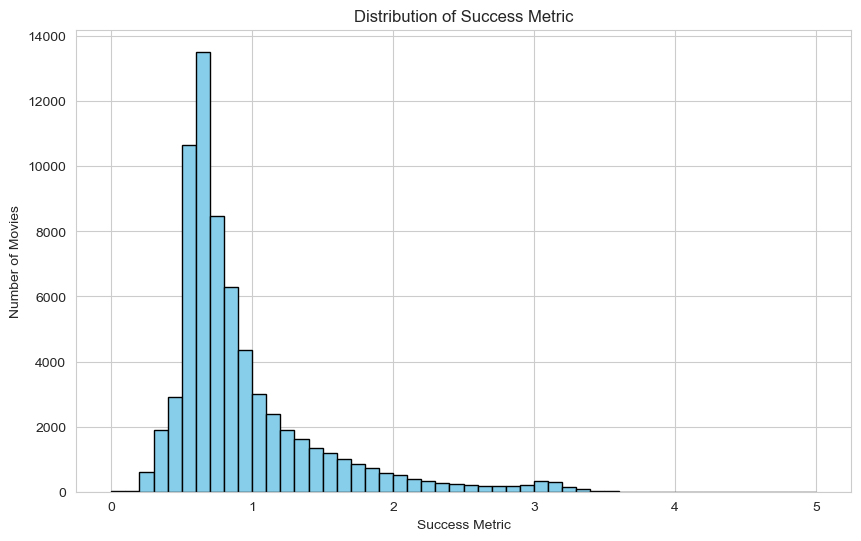

In [23]:
# Create a histogram of the Success_metric
plt.figure(figsize=(10, 6))
plt.hist(data_box_office['success_metric_scaled'].dropna(), bins=50, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')

# Show the plot
plt.show()

In [24]:
data_box_office.to_pickle('./data/Success_Metric.pkl')

# Impact timeseries

Now that we have created our success metric. We can start implementing our impact timeseries. They represent the impact a movie genre has on the movie industry. The motivations behind the creation of these timeseries as well as the methods implemented to create them are explained in more details in the `methods.ipynb` notebook.

In [2]:
# We read the saved data. Allows to start running the notebook from here
success_df = pd.read_pickle('./data/Success_Metric.pkl')
success_df.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,0.143767,0.996126,United States of America,"[Film adaptation, Costume drama, Roadshow thea...",0.619947,1.0,0.785789,22.186218,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,0.149518,1.000000,United States of America,"[Romance Film, Musical, Fantasy, Family Film, ...",0.619947,1.0,0.696421,21.949103,4.944015
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,0.096125,0.567962,United States of America,"[Adventure, Children's/Family, Animation, Comi...",0.619947,1.0,0.684211,18.456170,4.119294
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,0.278692,0.442916,United States of America,"[Science Fiction, Adventure, Fantasy, Coming o...",0.619947,1.0,0.810947,17.836009,3.972866
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,0.785462,0.471324,United States of America,"[Tragedy, Costume drama, Historical fiction, A...",0.592075,1.0,0.714080,17.689057,3.938169


We only keep the columns of the dataframe that are of interest to us.

In [3]:
success_df = success_df[["combined_release_date", "movie_genres_final", "success_score"]]
success_df = success_df.explode('movie_genres_final')
success_df.head()

,combined_release_date,movie_genres_final,success_score
30973,1939-12-15,Film adaptation,22.186218
30973,1939-12-15,Costume drama,22.186218
30973,1939-12-15,Roadshow theatrical release,22.186218
30973,1939-12-15,Epic,22.186218
30973,1939-12-15,Period piece,22.186218


We are going to limit our impact analysis to the genres that have more than 3000 movies. 

In [4]:
genre_counts = success_df['movie_genres_final'].value_counts()
genres_to_keep = genre_counts[genre_counts > 3000].index
success_filtered_df = success_df[success_df['movie_genres_final'].isin(genres_to_keep)]
success_filtered_df.head()

,combined_release_date,movie_genres_final,success_score
30973,1939-12-15,Drama,22.186218
30973,1939-12-15,Romantic drama,22.186218
30973,1939-12-15,Romance Film,22.186218
9888,1937-12-21,Romance Film,21.949103
9888,1937-12-21,Musical,21.949103


We can start generating our impact timeseries. For this, we call the `impact_genre` function which takes as input a dataframe with all the movies in a given genre.  

Here are the total number of movies for each genre:
Genre: Drama, Number of Movies: 30088
Genre: Comedy, Number of Movies: 15138
Genre: Romance Film, Number of Movies: 9156
Genre: Thriller, Number of Movies: 8073
Genre: Black-and-white, Number of Movies: 7977
Genre: Action, Number of Movies: 7848
Genre: World cinema, Number of Movies: 6929
Genre: Crime Fiction, Number of Movies: 6298
Genre: Indie, Number of Movies: 5959
Genre: Short Film, Number of Movies: 5568
Genre: Horror, Number of Movies: 4731
Genre: Adventure, Number of Movies: 4563
Genre: Action/Adventure, Number of Movies: 4413
Genre: Family Film, Number of Movies: 4135
Genre: Documentary, Number of Movies: 3964
Genre: Silent film, Number of Movies: 3725
Genre: Musical, Number of Movies: 3652
Genre: Comedy film, Number of Movies: 3438
Genre: Romantic drama, Number of Movies: 3240


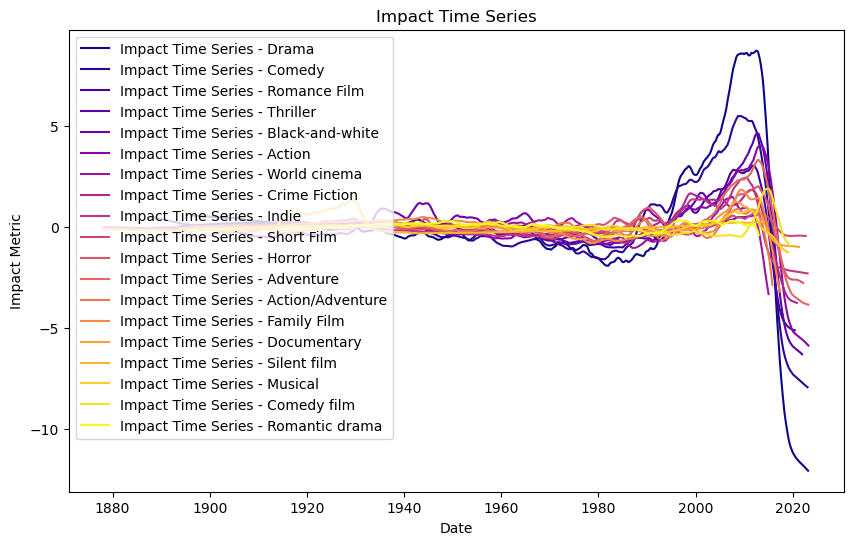

In [5]:
success_df_by_genre = {}
impact_timeseries_by_genre = {}

cmap = cm.get_cmap("plasma", len(genres_to_keep))
genre_colors = {genre: cmap(i) for i, genre in enumerate(genres_to_keep)}

for genre in genres_to_keep:
    success_df_by_genre[genre] = success_filtered_df[success_filtered_df['movie_genres_final'] == genre]

print("Here are the total number of movies for each genre:")

plt.figure(figsize=(10, 6))
for genre, genre_df in success_df_by_genre.items():
    print(f"Genre: {genre}, Number of Movies: {len(genre_df)}")
    impact_timeseries_by_genre[genre] = impact_genre(genre_df)

    plt.plot(impact_timeseries_by_genre[genre], label=f"Impact Time Series - {genre}", color=genre_colors[genre])
    plt.title("Impact Time Series")
    plt.xlabel("Date")
    plt.ylabel("Impact Metric")
    plt.legend()

plt.show()

We can see that we get some nice timeseries. The bad results at the end come from lack of movie data. We can now make some more detailed analysis on these and also start working on the prediction. But we first start by saving the processed data into a `.pkl` file so that we don't have to re-run this process everytime.

In [6]:
output_dir = "./data/Impact_Timeseries/"
os.makedirs(output_dir, exist_ok=True)

for genre, timeseries in impact_timeseries_by_genre.items():
    genre = genre.replace(" ", "_")
    genre = genre.replace("/", "-")
    save_path = os.path.join(output_dir, f"{genre}.csv")
    print(f"Saving to: {save_path}")
    timeseries.to_csv(save_path)

Saving to: ./data/Impact_Timeseries/Drama.csv
Saving to: ./data/Impact_Timeseries/Comedy.csv
Saving to: ./data/Impact_Timeseries/Romance_Film.csv
Saving to: ./data/Impact_Timeseries/Thriller.csv
Saving to: ./data/Impact_Timeseries/Black-and-white.csv
Saving to: ./data/Impact_Timeseries/Action.csv
Saving to: ./data/Impact_Timeseries/World_cinema.csv
Saving to: ./data/Impact_Timeseries/Crime_Fiction.csv
Saving to: ./data/Impact_Timeseries/Indie.csv
Saving to: ./data/Impact_Timeseries/Short_Film.csv
Saving to: ./data/Impact_Timeseries/Horror.csv
Saving to: ./data/Impact_Timeseries/Adventure.csv
Saving to: ./data/Impact_Timeseries/Action-Adventure.csv
Saving to: ./data/Impact_Timeseries/Family_Film.csv
Saving to: ./data/Impact_Timeseries/Documentary.csv
Saving to: ./data/Impact_Timeseries/Silent_film.csv
Saving to: ./data/Impact_Timeseries/Musical.csv
Saving to: ./data/Impact_Timeseries/Comedy_film.csv
Saving to: ./data/Impact_Timeseries/Romantic_drama.csv


Here are some plots that could be used for the website.

<Figure size 1200x800 with 0 Axes>

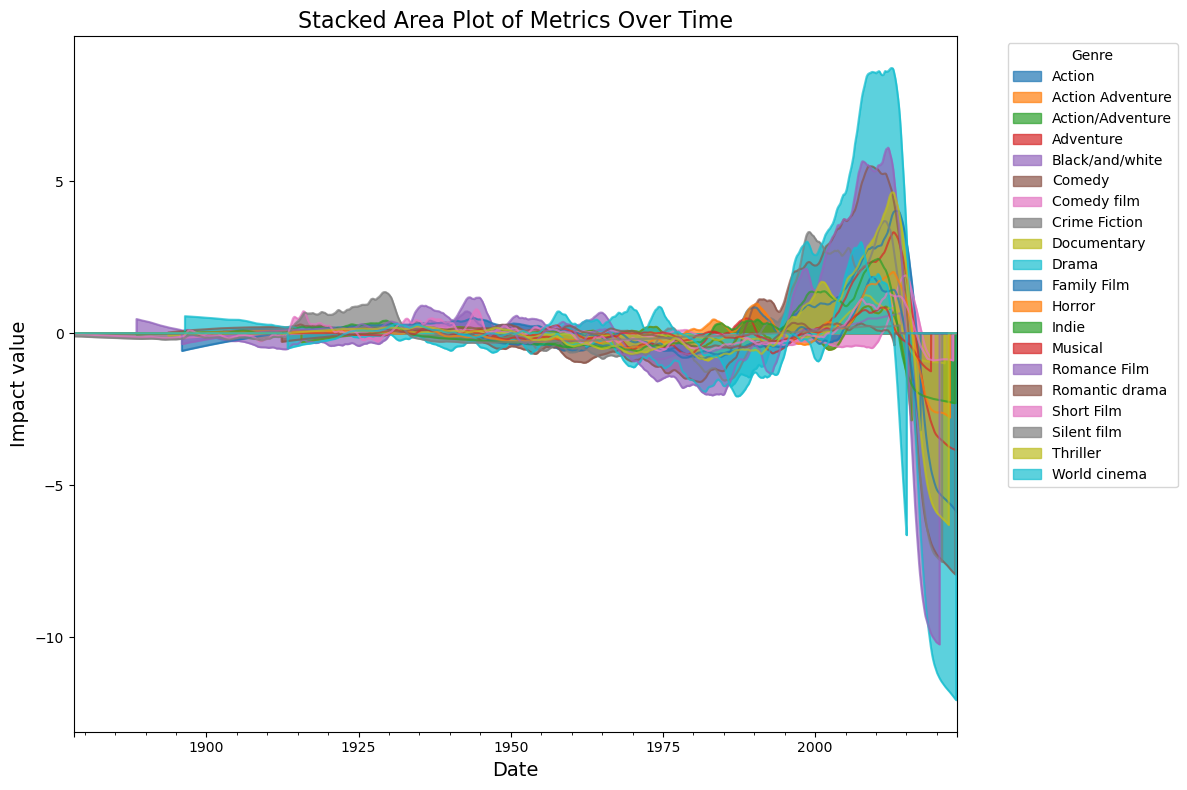

In [22]:
impact_data_dir = "./data/Impact_Timeseries/"
impact_array = []

for file_name in os.listdir(impact_data_dir):
    if file_name.endswith(".csv"): 
        genre_name = file_name.replace(".csv", "").replace("_", " ").replace("-", "/")
        file_path = os.path.join(output_dir, file_name)
        df = pd.read_csv(file_path, names=["Date", "Impact"], header=0, parse_dates=['Date'])
        df = df.drop(index=0)
        df['Genre'] = genre_name  
        impact_array.append(df)

combined_df = pd.concat(impact_array, ignore_index=True)

pivot_df = combined_df.pivot_table(index='Date', columns='Genre', values='Impact', aggfunc='sum')
pivot_df = pivot_df.fillna(0) 

plt.figure(figsize=(12, 8))
pivot_df.plot(kind='area', stacked=False, figsize=(12, 8), alpha=0.7)
plt.title("Stacked Area Plot of Metrics Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Impact value", fontsize=14)
plt.legend(title="Genre", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# Prediction on timeseries

For the prediction part, we need to choose when to take the cutoff point. We can see from the data that altough we have some information about movies until very recently, there seems to be a large drop off around 2010. This seems to be the point where our merged dataset doesn't have all up to date movie information. We are going thus going to set our prediction data around 2010. 

In [2]:
# We load the data from the data folder
output_dir = "./data/Impact_Timeseries/"
timeseries_load_impact_by_genre = {}

for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)

    if file_name.endswith(".csv"):
        genre = os.path.splitext(file_name)[0]
        genre = genre.replace("-", " / ").replace("_", " ")
        
        timeseries = pd.read_csv(file_path, index_col=0)  
        timeseries.index = pd.to_datetime(timeseries.index)
        timeseries = timeseries.asfreq('D')
        timeseries_load_impact_by_genre[genre] = timeseries


We are at genre: Action / Adventure


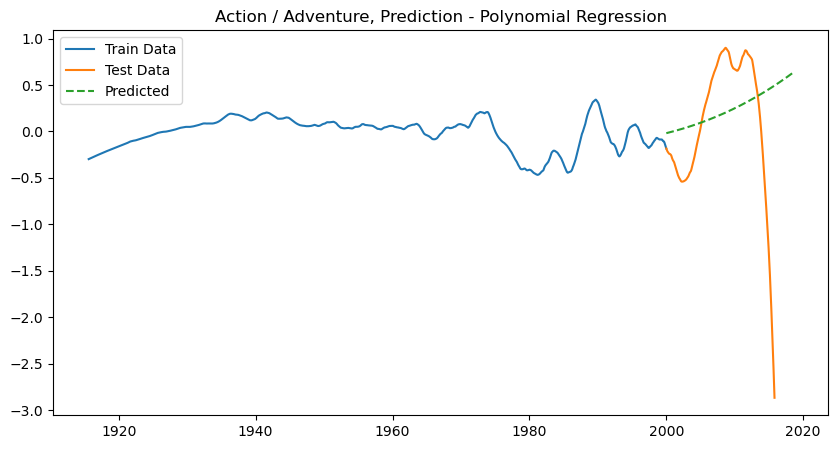

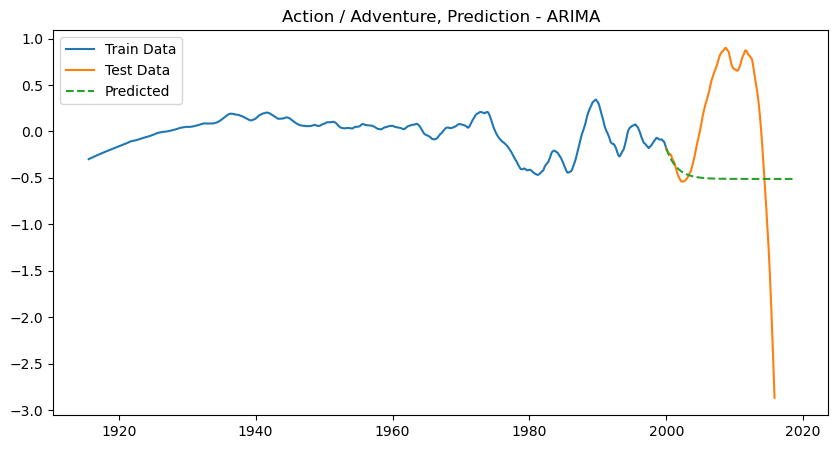

We are at genre: Action


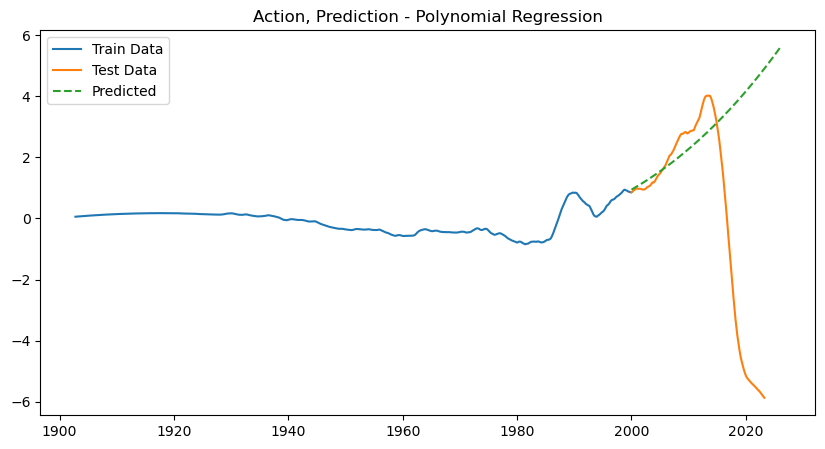

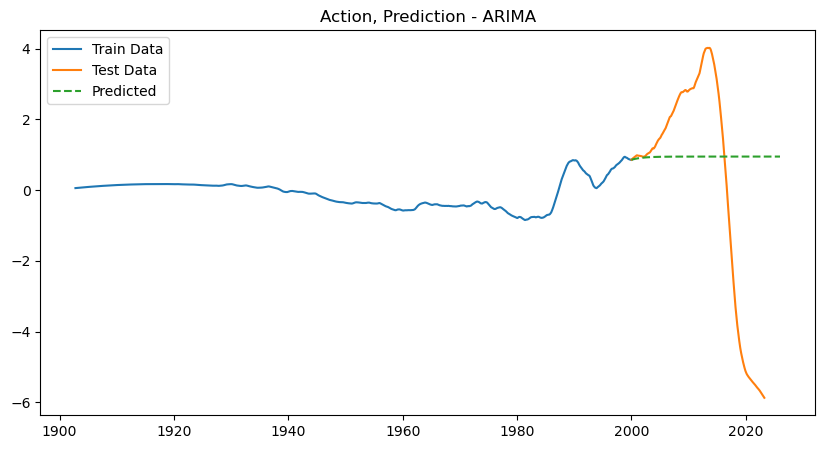

We are at genre: Action Adventure


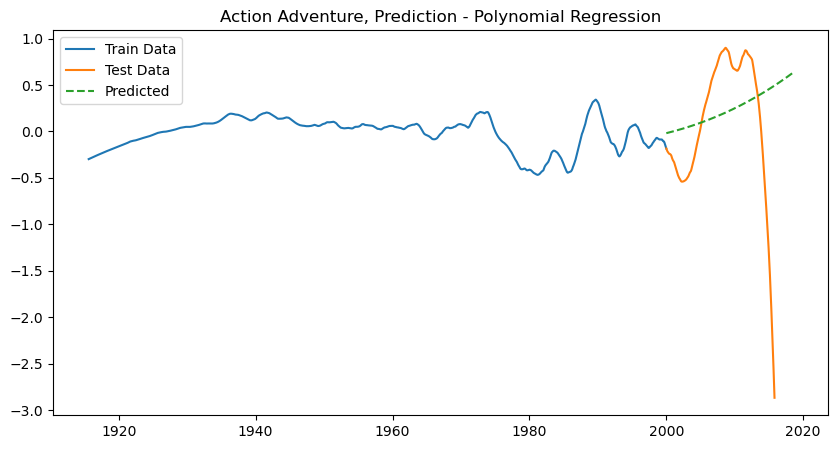

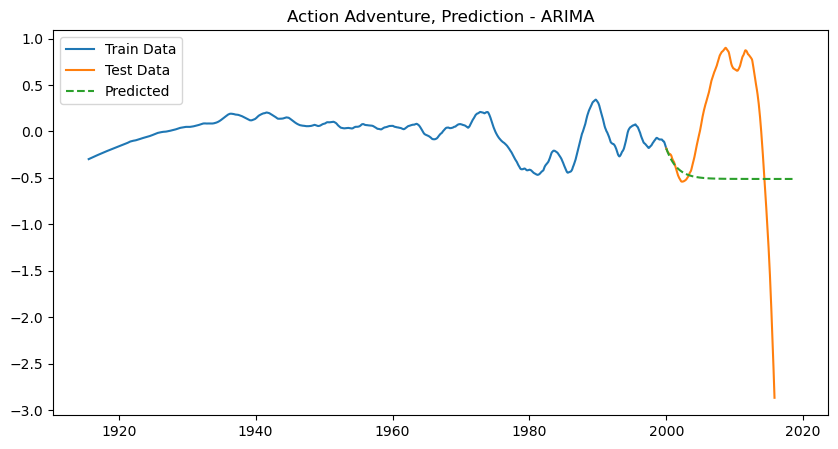

We are at genre: Adventure


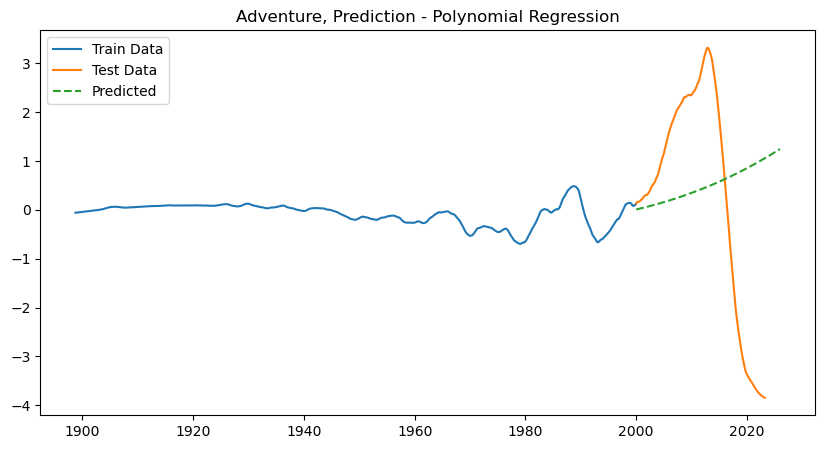

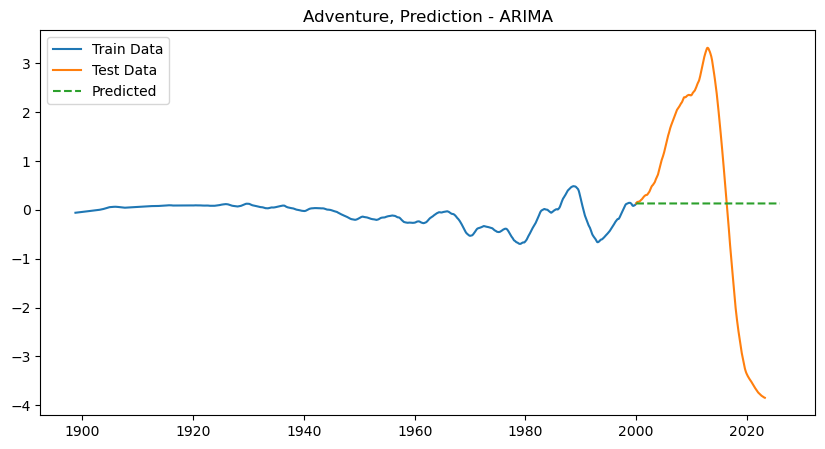

We are at genre: Black / and / white


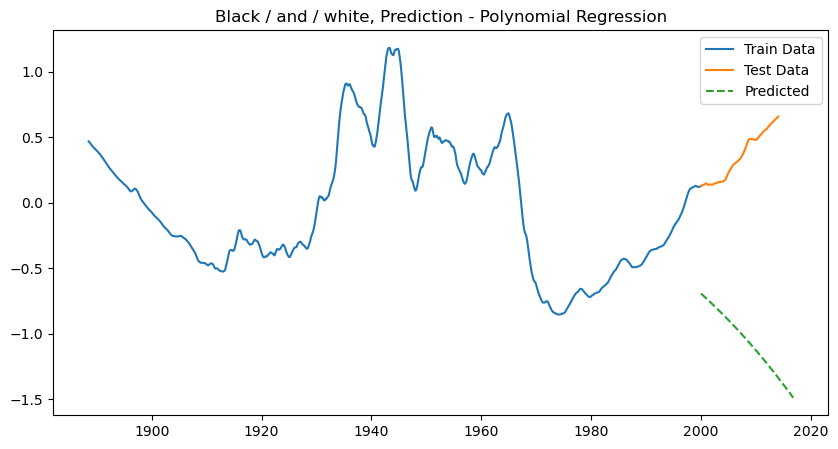

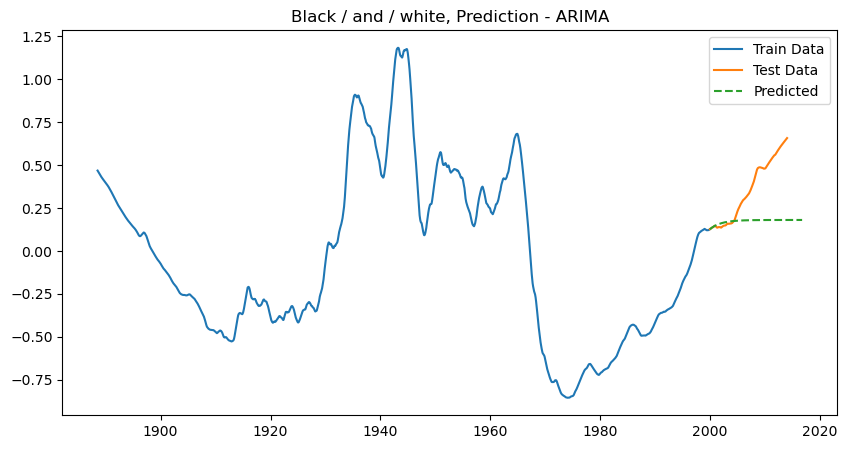

We are at genre: Comedy


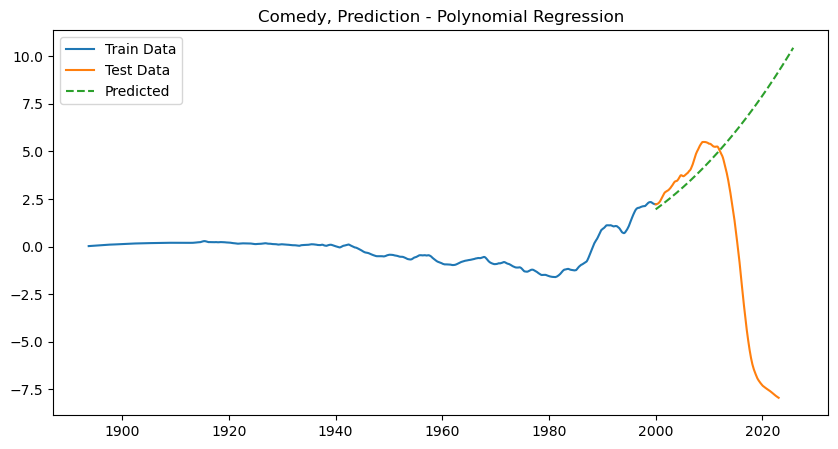

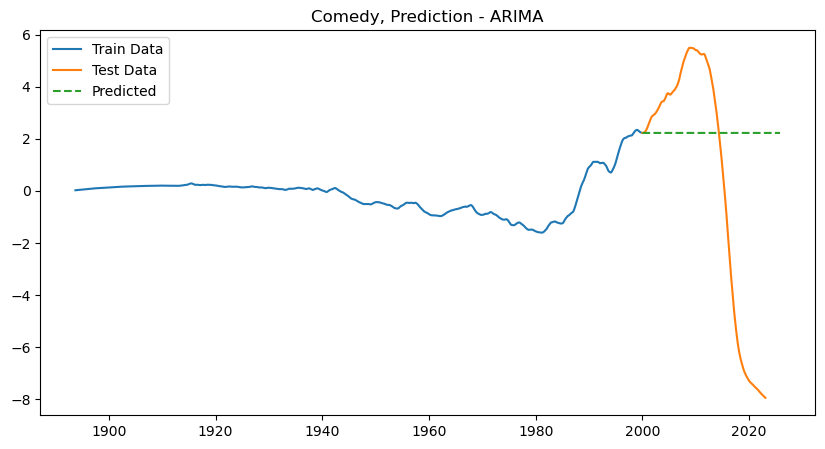

We are at genre: Comedy film


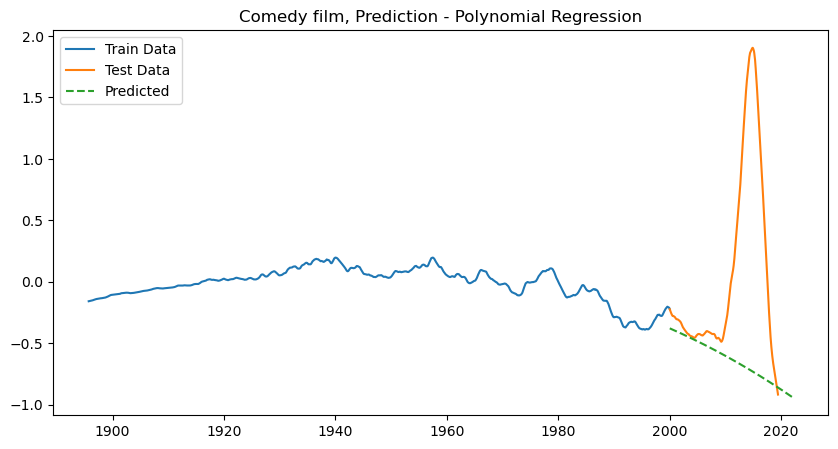

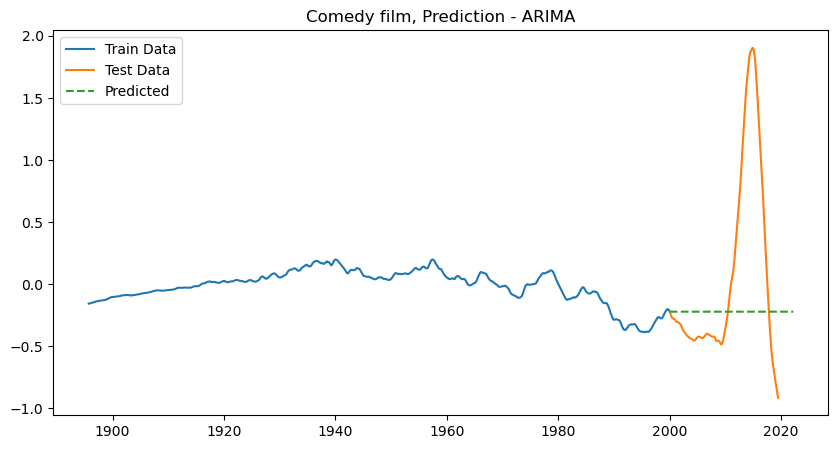

We are at genre: Crime Fiction


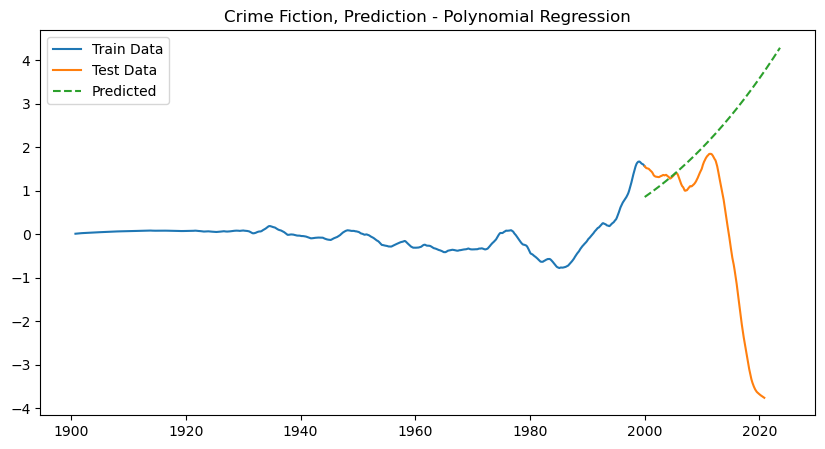

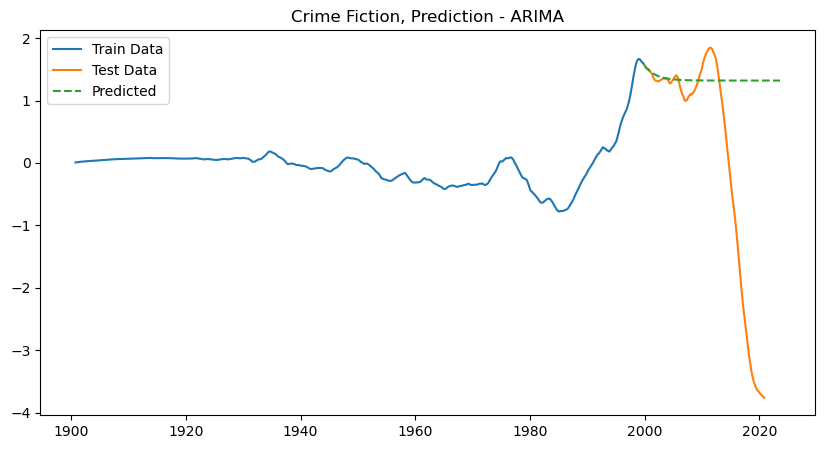

We are at genre: Documentary


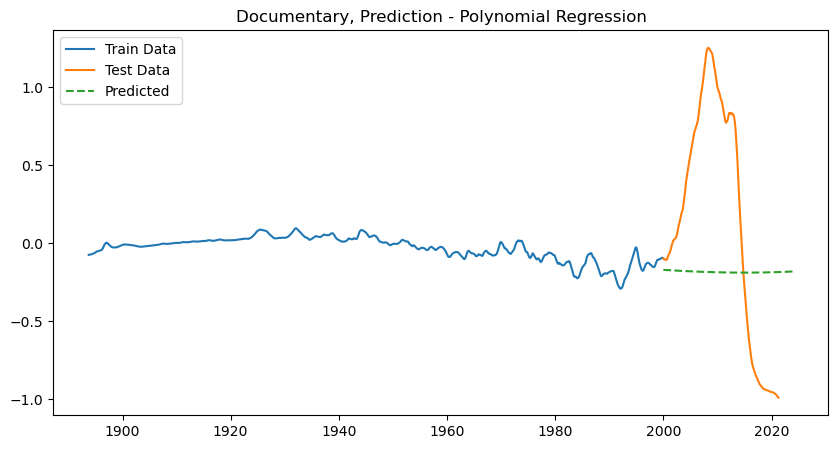

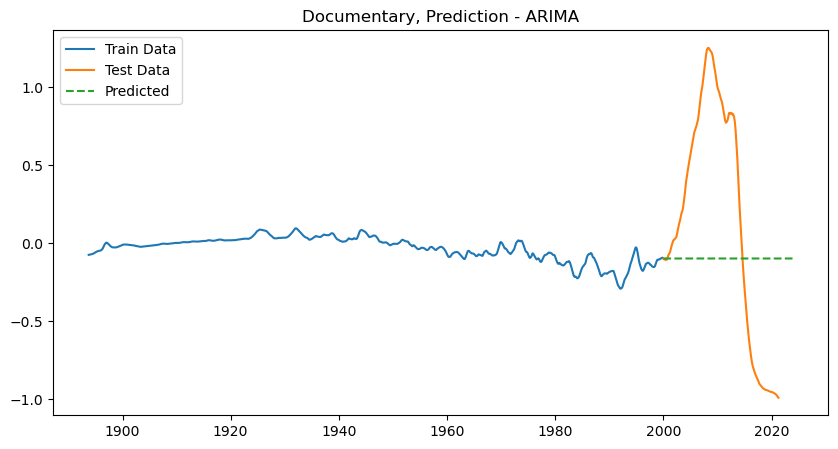

We are at genre: Drama


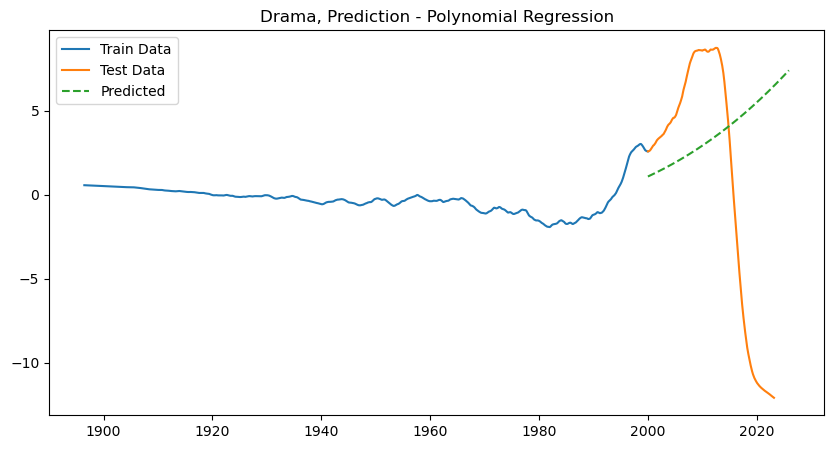

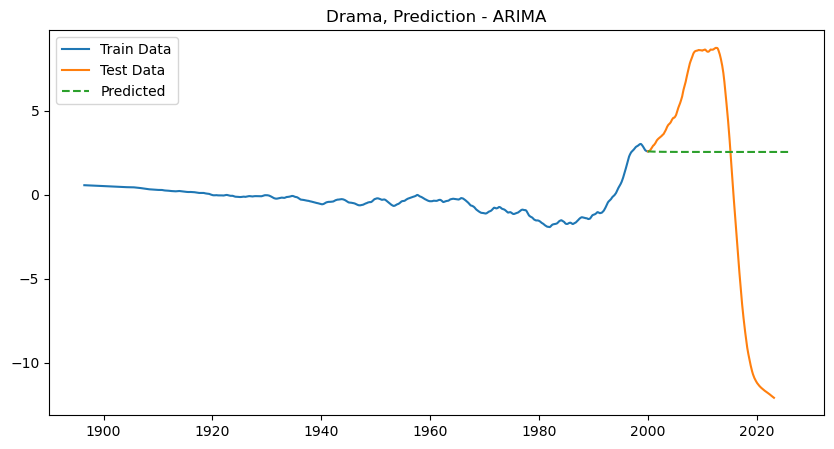

We are at genre: Family Film


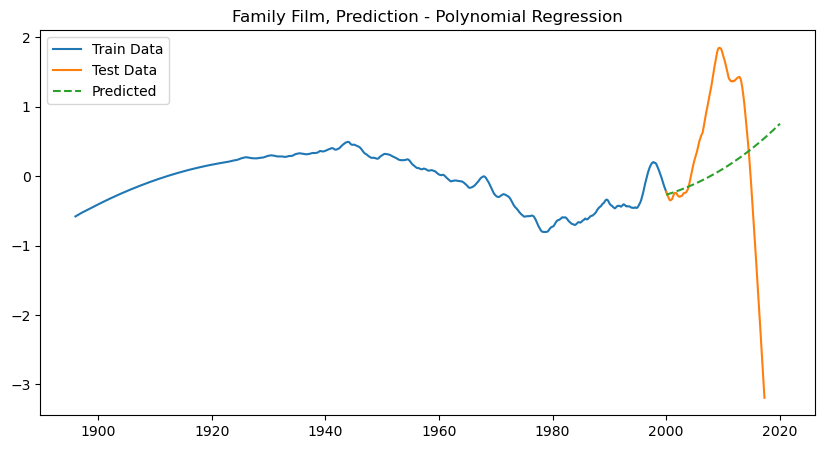

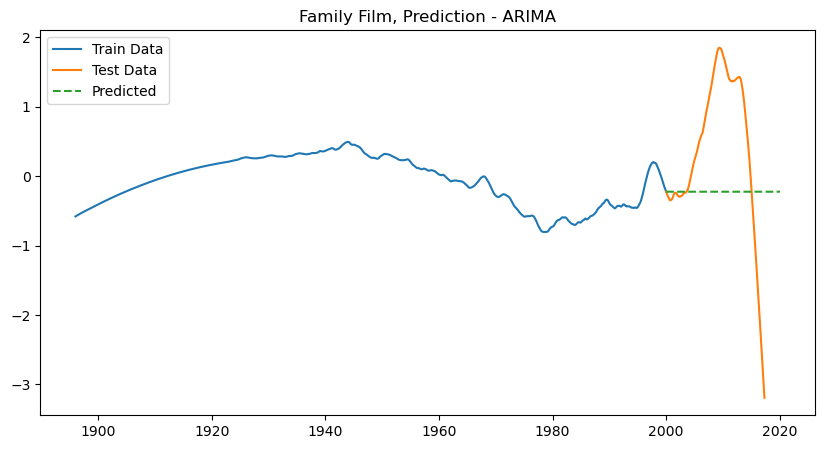

We are at genre: Horror


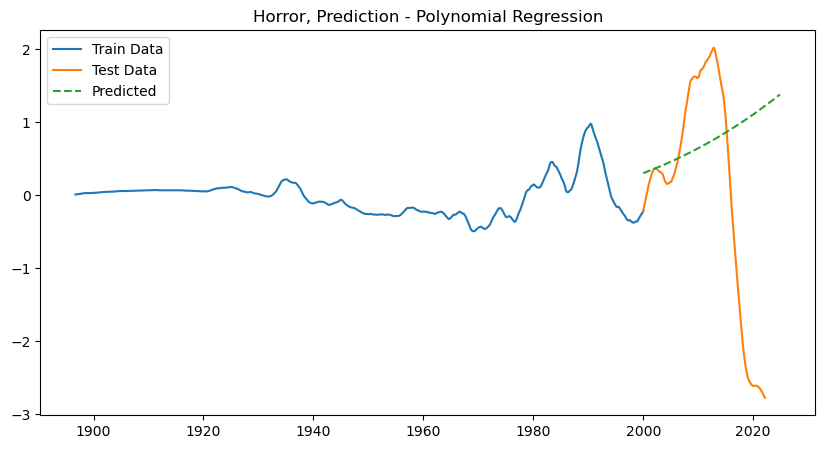

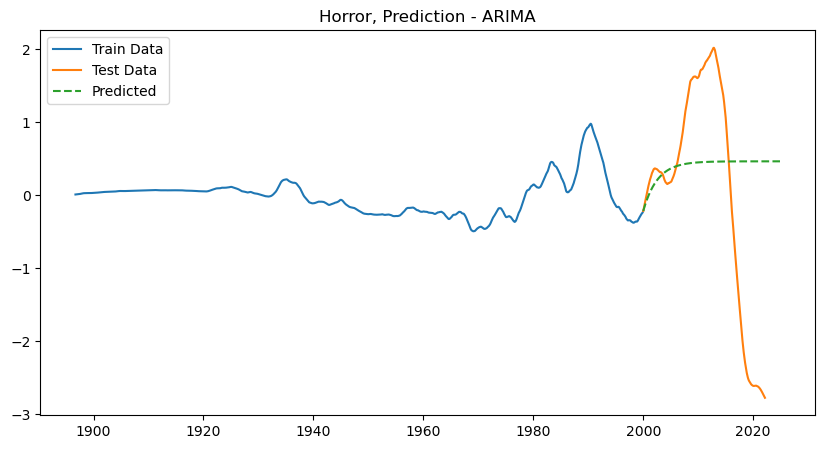

We are at genre: Indie


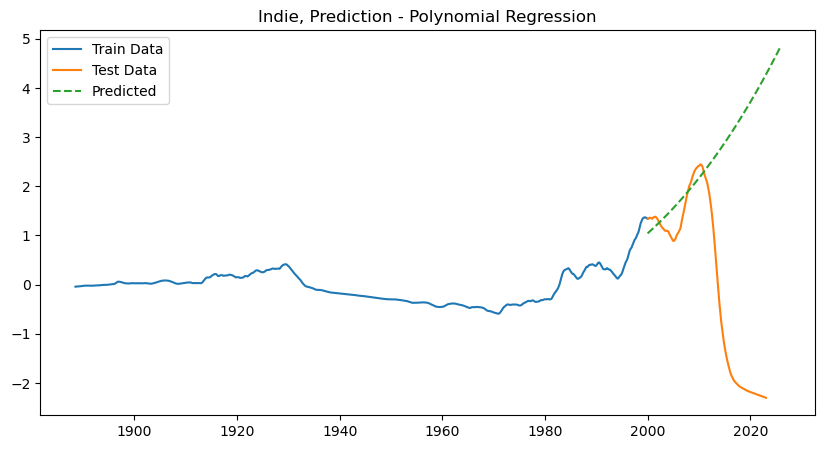

LinAlgError: Schur decomposition solver error.

In [3]:
cutoff_year = 2000
prediction_length_days = 1000
polynomial_order = 3
arima_params = (5, 1, 5)

for genre, impact_series in timeseries_load_impact_by_genre.items(): 
    print(f"We are at genre: {genre}")

    if isinstance(impact_series, pd.DataFrame):
        impact_series = impact_series.iloc[:, 0]

    cutoff_date = pd.Timestamp(f'{cutoff_year}-01-01')
    train = impact_series[impact_series.index < cutoff_date]
    test = impact_series[impact_series.index >= cutoff_date]

    test_range = len(test) + prediction_length_days

    poly_predictions = polynomial_regression(train, degree=polynomial_order, n_forecast=test_range)
    plot_results(train, test, poly_predictions, f"{genre}, Prediction - Polynomial Regression")
    
    arima_predictions = arima(train, order=arima_params, n_forecast=test_range)
    plot_results(train, test, arima_predictions, f"{genre}, Prediction - ARIMA")
